<center>

## Scapegoating Simulation   

</center> 


Created variable: G_ER_n30_seed42
Created variable: G_WS_n30_seed42
Created variable: G_BA_n30_seed42
Created variable: G_SBM_n30_seed42


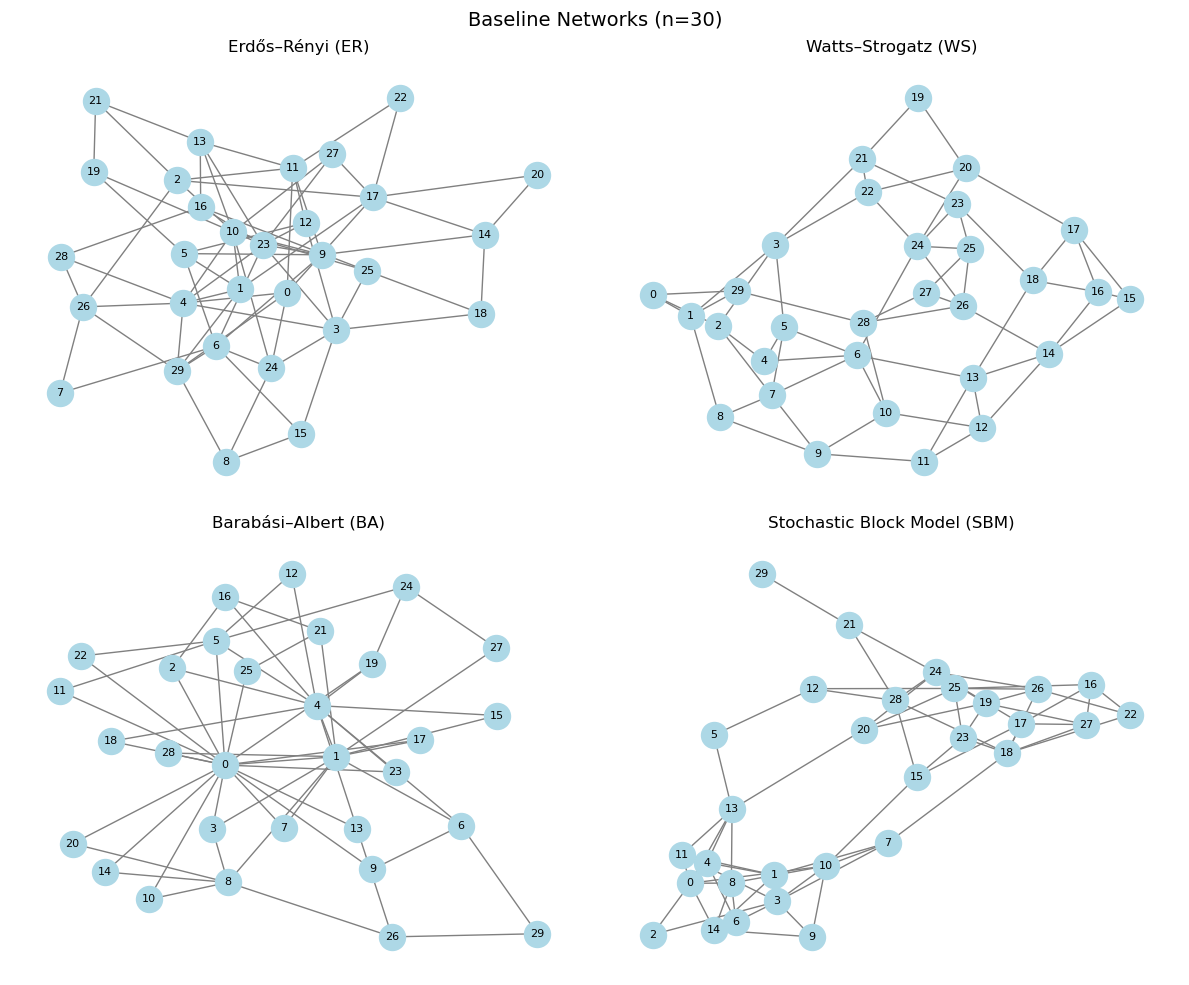

In [ ]:
# ============================
# Step 1 — Baseline networks with dynamic variable names
# Generates 4 network models (ER / WS / BA / SBM)
# Each network object is saved to a variable whose name includes n and seed
# ============================

import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

def generate_graph(model="ER", n=30, seed=42, ensure_connected=True, max_tries=1000, **kwargs):
    """(Same as before)"""
    rng = random.Random(seed)
    def _make_once(s):
        if model.upper() == "ER":
            p = kwargs.get("p", 0.15)
            return nx.fast_gnp_random_graph(n, p, seed=s)
        elif model.upper() == "WS":
            k = kwargs.get("k", 4); beta = kwargs.get("beta", 0.2)
            if k % 2 == 1: k += 1
            k = max(2, min(k, n - 1 - (n - 1) % 2))
            return nx.watts_strogatz_graph(n, k, beta, seed=s)
        elif model.upper() == "BA":
            m = kwargs.get("m", 2)
            return nx.barabasi_albert_graph(n, m, seed=s)
        elif model.upper() == "SBM":
            sizes = kwargs.get("sizes", [n // 2, n - n // 2])
            p_in = kwargs.get("p_in", 0.25); p_out = kwargs.get("p_out", 0.02)
            probs = np.full((2, 2), p_out); np.fill_diagonal(probs, p_in)
            return nx.stochastic_block_model(sizes, probs, seed=s)
        else:
            raise ValueError(f"Unknown model: {model}")

    G = _make_once(seed)
    if not ensure_connected:
        return G
    if nx.is_connected(G):
        return G
    for _ in range(max_tries):
        s = rng.randint(0, 10**9)
        G = _make_once(s)
        if nx.is_connected(G):
            return G
    largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc).copy()


def create_baseline_networks(n=30, seed=42):
    # 1. Generate
    G_ER  = generate_graph("ER",  n=n, p=0.15, seed=seed)
    G_WS  = generate_graph("WS",  n=n, k=4, beta=0.2, seed=seed)
    G_BA  = generate_graph("BA",  n=n, m=2, seed=seed)
    G_SBM = generate_graph("SBM", n=n, seed=seed, p_in=0.25, p_out=0.02)

    graphs = {
        "ER": G_ER,
        "WS": G_WS,
        "BA": G_BA,
        "SBM": G_SBM,
    }

    # 2. assign variable names
    for key, G in graphs.items():
        var_name = f"G_{key}_n{n}_seed{seed}"
        globals()[var_name] = G
        print(f"Created variable: {var_name}")

    # 3. Visualize
    plt.figure(figsize=(12, 10))
    titles = {
        "ER":  "Erdős–Rényi (ER)",
        "WS":  "Watts–Strogatz (WS)",
        "BA":  "Barabási–Albert (BA)",
        "SBM": "Stochastic Block Model (SBM)",
    }

    for i, (name, G) in enumerate(graphs.items(), 1):
        pos = nx.spring_layout(G, seed=seed)
        plt.subplot(2, 2, i)
        nx.draw_networkx(G, pos,
                         node_color="lightblue",
                         edge_color="gray",
                         node_size=350,
                         font_size=8,
                         with_labels=True)
        plt.title(titles[name])
        plt.axis("off")

    plt.suptitle(f"Baseline Networks (n={n})", fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

create_baseline_networks(n=30, seed=42)
# create_baseline_networks(n=50, seed=99)


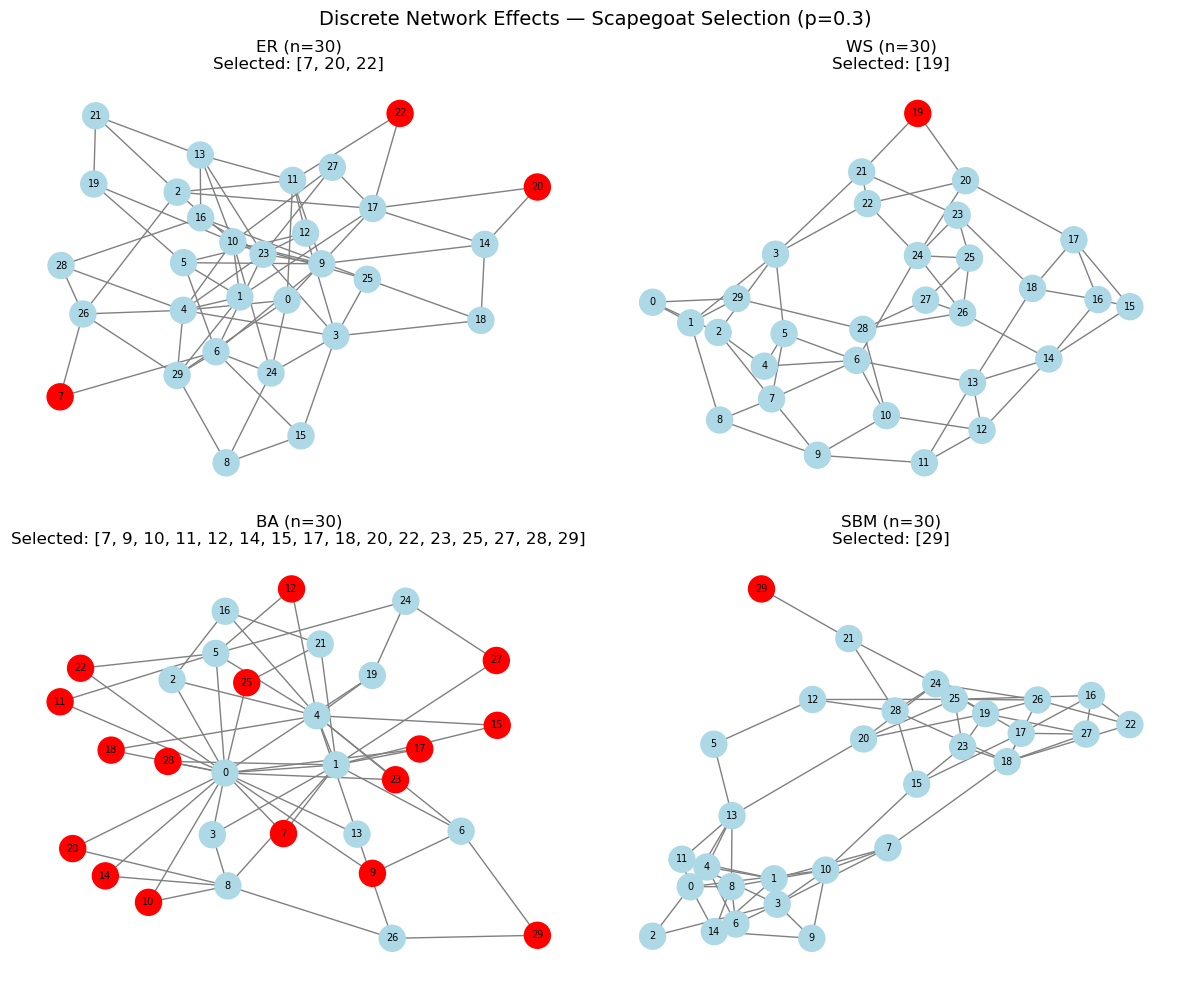

In [ ]:
# ============================
# Step 2 — Discrete Network Effects
# ============================

import networkx as nx
import matplotlib.pyplot as plt

def posterior_b_discrete(G, k, p: float):
    neighbors_k = set(G.neighbors(k))
    non_neighbor_val = 1.0 / (1.0 + p)
    b = {}
    for i in G.nodes():
        b[i] = 0.0 if i in neighbors_k else non_neighbor_val
    return b

def reputational_cost_R_discrete(G, k, p: float) -> float:
    n = G.number_of_nodes()
    deg_k = G.degree(k)
    factor = 1.0 - 1.0 / (1.0 + p)  # = p / (1 + p)
    return (n - deg_k) * factor + deg_k

def scapegoat_selection_discrete(G, p: float):
    R_map, b_map = {}, {}
    for k in G.nodes():
        b_map[k]  = posterior_b_discrete(G, k, p)
        R_map[k]  = reputational_cost_R_discrete(G, k, p)
    min_R = min(R_map.values())
    scapegoats = [k for k, val in R_map.items() if abs(val - min_R) < 1e-12]
    return scapegoats, R_map, b_map

def visualize_discrete_selection(G, p: float = 0.3, title: str = None, pos=None,
                                 highlight_color="red", base_color="lightblue"):
    scapegoats, R_map, _ = scapegoat_selection_discrete(G, p=p)
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    node_colors = [highlight_color if n in scapegoats else base_color for n in G.nodes()]
    labels = {n: str(n) for n in G.nodes()}

    plt.figure(figsize=(7, 6))
    nx.draw_networkx(G, pos, node_color=node_colors, edge_color="gray",
                     node_size=700, with_labels=False)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
    ttl = title if title is not None else f"Discrete Effects (p={p}) — minimize R(k) | Selected: {scapegoats}"
    plt.title(ttl)
    plt.axis("off")
    plt.show()

    print("Selected scapegoat(s) under DISCRETE:", scapegoats)
    for k in sorted(R_map):
        print(f"Node {k}: degree={G.degree(k)}, R^(k)={R_map[k]:.4f}")

def visualize_discrete_on_four_baselines(graphs_dict: dict, p: float = 0.3, layout_seed: int = 42):
    # Ensure consistent ordering if a plain dict is passed
    ordered_items = list(graphs_dict.items())

    plt.figure(figsize=(12, 10))
    for i, (name, G) in enumerate(ordered_items, 1):
        scapegoats, R_map, _ = scapegoat_selection_discrete(G, p=p)
        pos = nx.spring_layout(G, seed=layout_seed)
        node_colors = ["red" if n in scapegoats else "lightblue" for n in G.nodes()]
        labels = {n: str(n) for n in G.nodes()}
        clean_name = name.split(", seed")[0] + ")"

        plt.subplot(2, 2, i)
        nx.draw_networkx(G, pos, node_color=node_colors, edge_color="gray",
                         node_size=350, with_labels=False, font_size=8)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)
        plt.title(f"{clean_name}\nSelected: {scapegoats}")
        plt.axis("off")

    plt.suptitle("Discrete Network Effects — Scapegoat Selection (p=0.3)", fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()


# 1. Single graph:
# visualize_discrete_selection(G_ER_n30_seed42, p=0.3, title="Discrete (ER, n=30, seed=42)")

# 2. Four baselines at once:
graphs = {
    "ER (n=30, seed=42)":  G_ER_n30_seed42,
    "WS (n=30, seed=42)":  G_WS_n30_seed42,
    "BA (n=30, seed=42)":  G_BA_n30_seed42,
    "SBM (n=30, seed=42)": G_SBM_n30_seed42,
}
visualize_discrete_on_four_baselines(graphs, p=0.3)


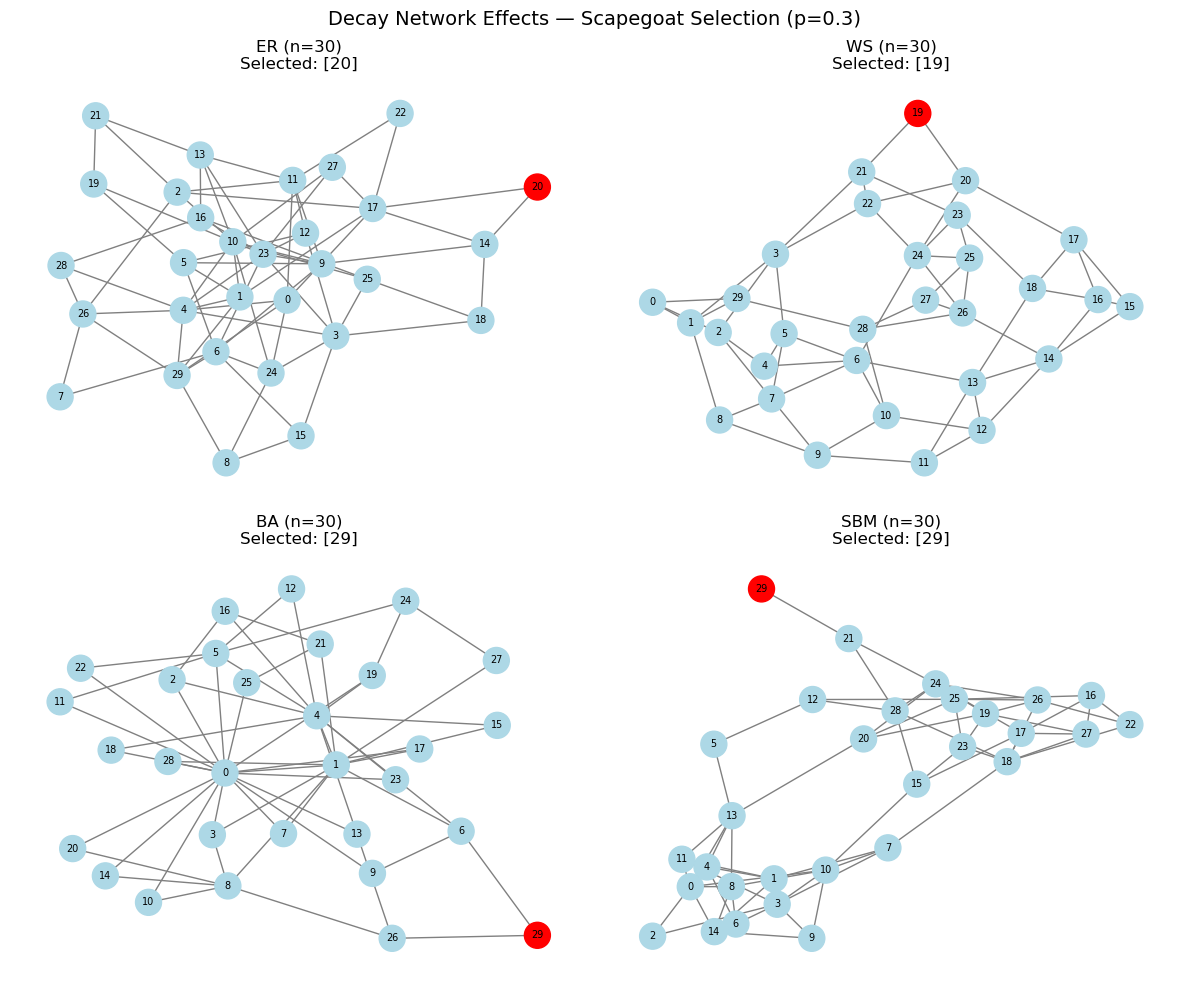

In [ ]:
# ============================
# Step 3 — Decay Network Effects
# ============================

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def decay_prior_pi(G, k):
    lengths = nx.single_source_shortest_path_length(G, k)
    pi = {}
    for i in G.nodes():
        if i == k:
            pi[i] = 0.0
        else:
            l = lengths.get(i, np.inf)
            if np.isinf(l):
                pi[i] = 0.5
            else:
                pi[i] = 0.5 - (0.5)**(l)
    return pi

def posterior_b_decay(pi_k: dict, p: float):
    b = {}
    for i, pi in pi_k.items():
        denom = pi + p * (1.0 - pi)
        b[i] = 0.0 if denom == 0 else (pi / denom)
    return b

def D_k_from_b(b_k: dict) -> float:
    """Aggregate disbelief"""
    return float(sum(1.0 - val for val in b_k.values()))

def scapegoat_selection_decay(G, p: float):
    D_map, b_map = {}, {}
    for k in G.nodes():
        pi_k = decay_prior_pi(G, k)
        b_k  = posterior_b_decay(pi_k, p)
        b_map[k] = b_k
        D_map[k] = D_k_from_b(b_k)
    min_D = min(D_map.values())
    scapegoats = [k for k, v in D_map.items() if abs(v - min_D) < 1e-12]
    return scapegoats, D_map, b_map

# Visualization
def visualize_decay_selection(G, p: float = 0.3, title: str = None, pos=None,
                              highlight_color="red", base_color="lightblue"):
    """
    Visualize DECAY-effect scapegoat selection on a single graph.
    - Highlights selected scapegoat node(s) in red
    - Nodes display only their IDs (no D_k on the nodes)
    - Title hides seed
    """
    scapegoats, D_map, _ = scapegoat_selection_decay(G, p=p)
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    node_colors = [highlight_color if n in scapegoats else base_color for n in G.nodes()]
    labels = {n: str(n) for n in G.nodes()}  # only IDs

    plt.figure(figsize=(7, 6))
    nx.draw_networkx(G, pos, node_color=node_colors, edge_color="gray",
                     node_size=700, with_labels=False)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
    ttl = title if title is not None else f"Decay Effects (p={p}) — minimize D_k | Selected: {scapegoats}"
    plt.title(ttl)
    plt.axis("off")
    plt.show()

    print("Selected scapegoat(s) under DECAY:", scapegoats)
    for k in sorted(D_map):
        print(f"Node {k}: degree={G.degree(k)}, D_k={D_map[k]:.4f}")

def visualize_decay_on_four_baselines(graphs_dict: dict, p: float = 0.3, layout_seed: int = 42):
    ordered_items = list(graphs_dict.items())
    plt.figure(figsize=(12, 10))

    for i, (name, G) in enumerate(ordered_items, 1):
        scapegoats, D_map, _ = scapegoat_selection_decay(G, p=p)
        pos = nx.spring_layout(G, seed=layout_seed)
        node_colors = ["red" if n in scapegoats else "lightblue" for n in G.nodes()]
        labels = {n: str(n) for n in G.nodes()}  # only IDs
        clean_name = name.split(", seed")[0] + ")"

        plt.subplot(2, 2, i)
        nx.draw_networkx(G, pos, node_color=node_colors, edge_color="gray",
                         node_size=350, with_labels=False, font_size=8)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)
        plt.title(f"{clean_name}\nSelected: {scapegoats}")
        plt.axis("off")

    plt.suptitle("Decay Network Effects — Scapegoat Selection (p=0.3)", fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

# 1. Single graph:
# visualize_decay_selection(G_ER_n30_seed42, p=0.3, title="Decay (ER, n=30)")

# 2. Four baselines at once:
graphs = {
    "ER (n=30, seed=42)":  G_ER_n30_seed42,
    "WS (n=30, seed=42)":  G_WS_n30_seed42,
    "BA (n=30, seed=42)":  G_BA_n30_seed42,
    "SBM (n=30, seed=42)": G_SBM_n30_seed42,
}
visualize_decay_on_four_baselines(graphs, p=0.3)


In [ ]:
# ============================
# Step 3.1: Computes Spearman rho(C_k, D_k)
# ============================

import numpy as np
import networkx as nx
import pandas as pd
from scipy.stats import spearmanr

ALPHA = 0.5                            # decay factor in C_k
# Log-spaced p with denser sampling at very small p; unique to avoid duplicates
P_GRID = np.unique(np.round(np.logspace(-3, 0, 50), 6))  # [0.001, 1.0]

SIZES = [60, 120]
GRAPHS_PER_SIZE = 20                 # number of random graphs per (model, n)
BOOTSTRAP_B = 1000                     # bootstrap reps for 95% CI (by graph)
RNG = np.random.default_rng(20251014)

OUT_PER_GRAPH = "rho_per_graph.csv"
OUT_AGG = "rho_agg_bootstrap.csv"
OUT_MONO = "rho_monotonicity_checks.csv"

def gen_er(n, seed):
    p = 0.08 if n == 60 else 0.05
    return nx.erdos_renyi_graph(n, p, seed=seed)

def gen_ws(n, seed):
    return nx.watts_strogatz_graph(n, k=4, p=0.2, seed=seed)

def gen_ba(n, seed):
    m = 2 if n == 60 else 3
    return nx.barabasi_albert_graph(n, m, seed=seed)

def gen_sbm(n, seed):
    blocks = 3
    sizes = [n//blocks + (1 if i < (n % blocks) else 0) for i in range(blocks)]
    pin = 0.08 if n == 60 else 0.05
    pout = 0.01 if n == 60 else 0.007
    P = np.full((blocks, blocks), pout, dtype=float)
    np.fill_diagonal(P, pin)
    return nx.stochastic_block_model(sizes, P, seed=seed)

MODELS = {"ER": gen_er, "WS": gen_ws, "BA": gen_ba, "SBM": gen_sbm}

def largest_connected_component(G):
    if nx.is_connected(G):
        return G
    comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()

def all_pairs_dist(G):
    """Return node list and shortest-path dict-of-dict (finite in LCC)."""
    D = dict(nx.all_pairs_shortest_path_length(G))
    nodes = list(G.nodes())
    dist = {u: {v: D[u][v] for v in nodes} for u in nodes}
    return nodes, dist

def decay_centrality(nodes, dist, alpha=ALPHA, include_self=True):
    """C_k = sum_i alpha^{l_ik}. include_self=True adds alpha^0=1."""
    n = len(nodes)
    C = np.zeros(n, dtype=float)
    for k_idx, k in enumerate(nodes):
        s = 1.0 if include_self else 0.0
        for i in nodes:
            if i == k:
                continue
            d = dist[i][k]
            s += alpha**d
        C[k_idx] = s
    return C

def D_vector(nodes, dist, p, include_self=True):
    """D_k = sum_i (1 - b_i^{(k)}),
       with pi = 0.5 - (0.5)^l, b = pi / (pi + p(1-pi))."""
    n = len(nodes)
    Dk = np.zeros(n, dtype=float)
    eps = 1e-12  # numerical guard for very small p
    for k_idx, k in enumerate(nodes):
        s = 1.0 if include_self else 0.0  # self term: pi=0 => b=0 => (1-b)=1
        for i in nodes:
            if i == k:
                continue
            d = dist[i][k]
            pi = 0.5 - (0.5)**d
            denom = pi + p*(1 - pi) + eps
            b = pi / denom
            s += (1 - b)
        Dk[k_idx] = s
    return Dk

def bootstrap_ci(measures, B=BOOTSTRAP_B, rng=RNG, alpha=0.05):
    """Graph-level bootstrap on an array of per-graph statistics (e.g., rho).
       Returns (mean, lo, hi)."""
    y = np.asarray(measures, dtype=float)
    if y.size == 0:
        return np.nan, np.nan, np.nan
    means = []
    m = y.size
    for _ in range(B):
        samp = rng.choice(y, size=m, replace=True)
        means.append(np.mean(samp))
    means = np.sort(np.array(means))
    lo = means[int(alpha/2 * B)]
    hi = means[int((1 - alpha/2) * B) - 1]
    return float(np.mean(y)), float(lo), float(hi)

# Per-graph simulation 
rows = []
for model_name, gen in MODELS.items():
    for n in SIZES:
        for _ in range(GRAPHS_PER_SIZE):
            seed = int(RNG.integers(0, 10_000_000))
            G = gen(n, seed)
            Gc = largest_connected_component(G)
            nodes, dist = all_pairs_dist(Gc)

            # precompute C once (independent of p)
            C = decay_centrality(nodes, dist, include_self=True)

            for p in P_GRID:
                Dk = D_vector(nodes, dist, p, include_self=True)
                rho = float(spearmanr(C, Dk).statistic)
                rows.append({
                    "model": model_name,
                    "n": n,
                    "seed": seed,
                    "num_nodes_LCC": len(nodes),
                    "p": p,
                    "spearman_rho": rho,
                })

df_graph = pd.DataFrame(rows)

# Aggregate by (model, n, p) with graph-bootstrap 95% CI
agg_rows = []
for (model_name, n), dfmn in df_graph.groupby(["model", "n"]):
    for p, dfp in dfmn.groupby("p"):
        mean_rho, lo_rho, hi_rho = bootstrap_ci(dfp["spearman_rho"].to_numpy())
        agg_rows.append({
            "model": model_name, "n": n, "p": p,
            "rho_mean": mean_rho, "rho_lo": lo_rho, "rho_hi": hi_rho,
            "graphs": int(dfp.shape[0]),
        })

df_agg = pd.DataFrame(agg_rows).sort_values(["model", "n", "p"])

# Monotonicity diagnostic 
mono_rows = []
EPS = 1e-8
for (model_name, n), dfmn in df_agg.groupby(["model", "n"]):
    dfmn = dfmn.sort_values("p")
    diffs = np.diff(dfmn["rho_mean"].to_numpy())
    violations = int((diffs < -EPS).sum())
    mono_rows.append({"model": model_name, "n": n, "nonmonotone_steps": violations})

print("Simulation complete.")

Simulation complete.


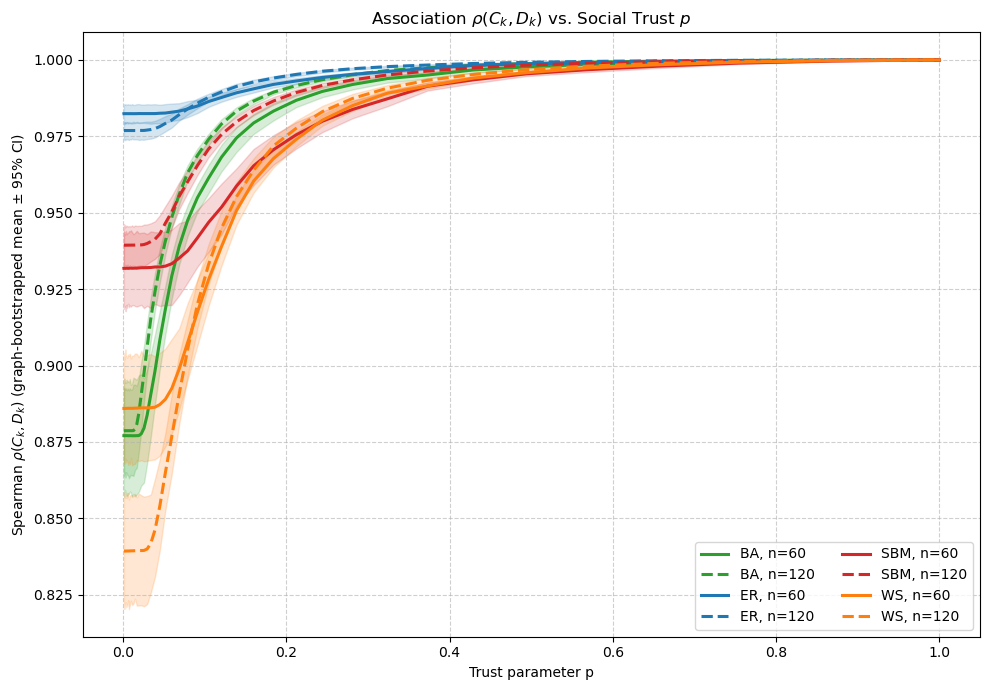

In [ ]:

# Plot

import matplotlib.pyplot as plt

IN_AGG = "rho_agg_bootstrap.csv" 
df = df_agg.copy()  

colors = {
    "ER": "#1f77b4",
    "WS": "#ff7f0e",
    "BA": "#2ca02c",
    "SBM": "#d62728",
}
linestyles = {60: "-", 120: "--"}

plt.figure(figsize=(10, 7))
for (model_name, n), dfmn in df.groupby(["model", "n"]):
    dfmn = dfmn.sort_values("p")
    label = f"{model_name}, n={n}"
    plt.plot(
        dfmn["p"], dfmn["rho_mean"],
        color=colors.get(model_name, "#333333"),
        linestyle=linestyles.get(int(n), "-"),
        linewidth=2.2,
        label=label,
    )
    plt.fill_between(
        dfmn["p"],
        dfmn["rho_lo"],
        dfmn["rho_hi"],
        color=colors.get(model_name, "#333333"),
        alpha=0.18,
    )

plt.xlabel("Trust parameter p")
plt.ylabel(r"Spearman $\rho(C_k, D_k)$ (graph-bootstrapped mean ± 95% CI)")
plt.title(r"Association $\rho(C_k, D_k)$ vs. Social Trust $p$")
plt.legend(ncol=2)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Model Extensions: Behavioral and Stochastic Heterogeneity

To better capture realistic heterogeneity and stochastic network effects,  
we introduce **four** minimal but essential extensions to the baseline model.  
These relax behavioral, cognitive, informational, and decisional assumptions  
while keeping the equilibrium structure intact.

---

### **Extension 1 — Heterogeneous Conformity (Behavioral Layer)**

Each agent $i$ has an individual conformity parameter $\alpha_i \in [0,1]$,  
which measures how much the agent values social conformity versus private belief.

$$
u_i = -(1-\alpha_i)(x_i - b_i)^2 - \alpha_i \sum_j w_{ij} (x_i - x_j)^2
$$

The equilibrium opinion vector satisfies:

$$
\big(\mathrm{diag}(1-\alpha) + \mathrm{diag}(\alpha)L\big)\,x^* = (1-\alpha)\odot b
$$

- $\alpha_i$: conformity / stubbornness (drawn from $U(0,1)$)  
- $L$: graph Laplacian ($L = D - W$)  
- $b_i$: posterior belief from the signal-update stage  

This extension introduces **behavioral heterogeneity**, producing realistic mixtures of conformists and stubborn individuals.

---

### **Extension 2 — Heterogeneous Trust (Cognitive Layer)**

Agents differ in how credulous they are toward the leader’s accusation.  
Each $p_i \in (0,1)$ represents the **credence** or “light-trust” parameter of individual $i$.

$$
p_i = \sigma(\mu_p + \eta_i), \qquad \eta_i \sim \mathcal N(0,\sigma_p^2)
$$

Given a prior $\pi_i^{(k)}$, the posterior belief after observing the accusation is

$$
b_i^{(k)} = \frac{\pi_i^{(k)}}{\pi_i^{(k)} + p_i (1-\pi_i^{(k)})}
$$

- $\sigma(\cdot)$: logistic function $\sigma(z)=1/(1+e^{-z})$  
- $\mu_p$: average trust level (e.g., $0$)  
- $\sigma_p$: dispersion of trust heterogeneity (e.g., $1$)  

This captures **cognitive heterogeneity**—some individuals are credulous, others skeptical.

---

### **Extension 3 — Stochastic Priors (Informational Layer)**

Instead of a deterministic distance-based prior, each agent’s prior belief about the accused $k$ decays with distance but includes random noise.

$$
\pi_i^{(k)} = \sigma(\beta_0 + \beta_1\, d(i,k) + \varepsilon_i), \qquad \varepsilon_i \sim \mathcal N(0,\sigma_\pi^2)
$$

- $d(i,k)$: shortest-path distance from $i$ to $k$  
- $\beta_1 > 0$: slope of distance-based skepticism  
- $\beta_0$: baseline trust / overall belief bias  
- $\sigma_\pi$: noise level (idiosyncratic randomness)  

This ensures that **on average**, farther nodes are more skeptical  
($\mathbb{E}[\pi_i^{(k)} | d]$ increases in $d$),  
while random perturbations allow occasional over- or under-reaction—  
a simple yet realistic form of **stochastic network effects**.

---

### **Extension 4 — Stochastic Decision (Bounded Rationality Layer)**

After the equilibrium reputational costs $R^{(k)}$ are computed,  
the leader (or system) no longer selects scapegoats deterministically.  
Instead, it follows a **soft-min decision rule** representing bounded rationality:

$$
P(k) \propto \exp[-\lambda (R^{(k)} - \min_j R^{(j)})]
$$

where $\lambda > 0$ controls the “decision temperature.”  
When $\lambda \to \infty$, the model collapses to deterministic minimization;  
when $\lambda$ is smaller, near-optimal nodes also have a chance of being selected.

This captures **bounded rationality and stochastic choice**,  
transforming the deterministic scapegoat rule into a probabilistic one—  
a fourth layer of **decisional heterogeneity**.

---

### **Summary of Parameters**

| Symbol | Description | Typical Setting |
|:--:|:--|:--|
| $\alpha_i$ | individual conformity/stubbornness | $U(0,1)$ |
| $p_i$ | individual credence (trust in leader) | $p_i = \sigma(\mu_p + \eta_i),\; \mu_p=0,\; \sigma_p=1$ |
| $\pi_i^{(k)}$ | stochastic prior belief about $k$ | $\beta_0=-2,\; \beta_1=0.6,\; \sigma_\pi=0.5$ |
| $b_i^{(k)}$ | posterior belief | from Bayesian update |
| $L$ | graph Laplacian | $L = D - W$ |
| $w_{ij}$ | social weight (adjacency) | normalized adjacency |
| $d(i,k)$ | network distance | shortest-path length |
| $\lambda$ | bounded rationality / decision temperature | $\lambda = 10–25$ |

---

Together, these four extensions yield a **complex yet tractable framework** where  
heterogeneity in **behavior ($\alpha$)**, **trust ($p$)**, **information ($\pi$)**, and **decision ($\lambda$)**  
jointly determine the equilibrium and scapegoat selection dynamics in the simulation.


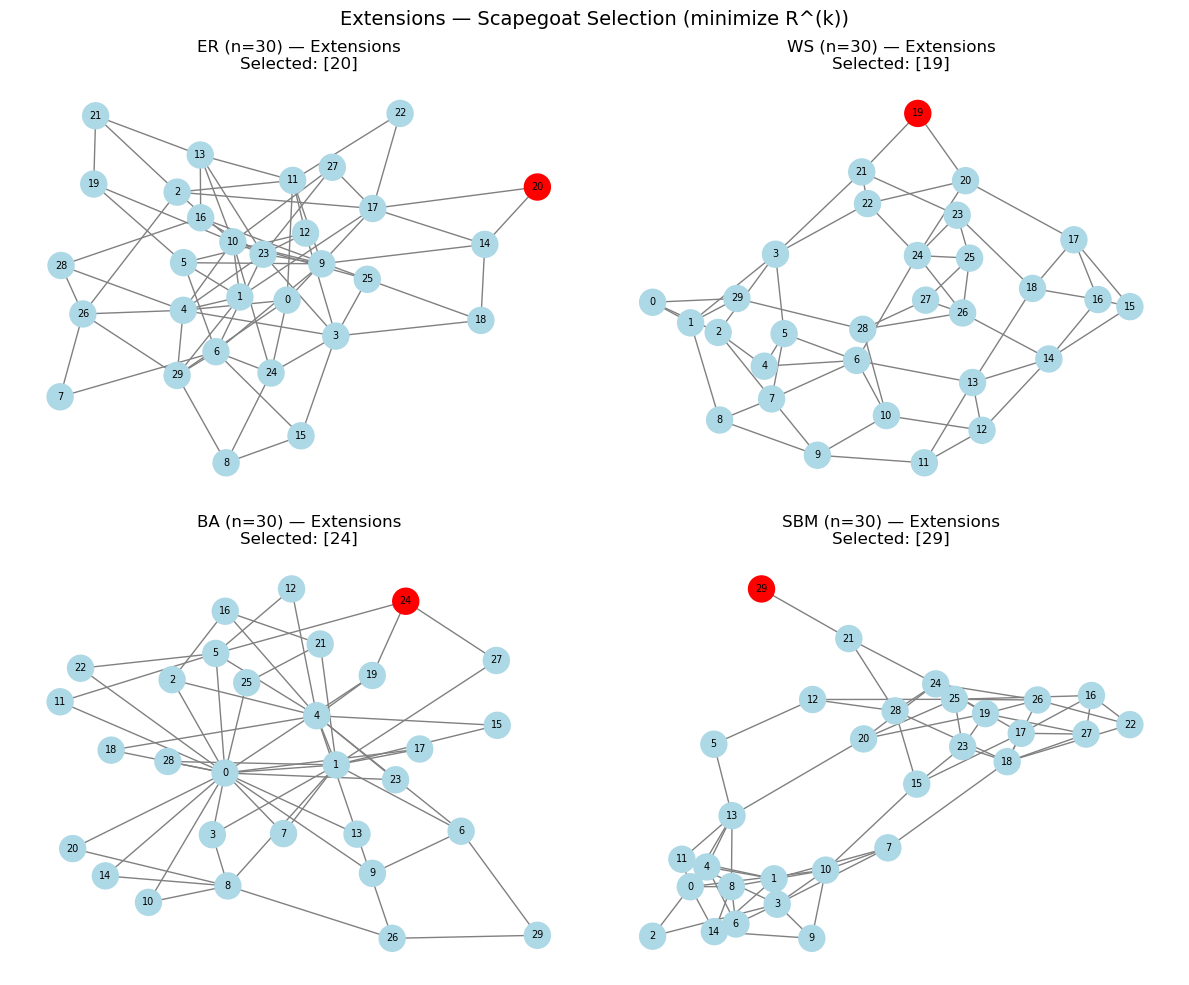

In [ ]:
# ============================
# Configuration + Replication
# ============================

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def _sigmoid(z): 
    return 1.0 / (1.0 + np.exp(-z))

def _rng_from(seed, *keys):
    """Deterministic child RNG derived from a base seed + keys (stable across runs)."""
    h = hash((seed,) + tuple(keys)) & 0xFFFFFFFF
    return np.random.default_rng(h)

def _laplacian(G):
    W = nx.to_numpy_array(G, weight=None)
    d = W.sum(axis=1)
    return np.diag(d) - W

# Parameter generators 
def sample_alpha_det(n, seed=0):
    rng = _rng_from(seed, "alpha")
    return rng.uniform(0.0, 1.0, size=n)

def sample_p_det(n, mu_p=0.0, sigma_p=1.0, seed=0):
    rng = _rng_from(seed, "p")
    eta = rng.normal(0.0, sigma_p, size=n)
    return _sigmoid(mu_p + eta)

def stochastic_prior_for_k_det(G, k, beta0=-2.0, beta1=0.6, sigma_eps=0.5, base_seed=0):
    rng = _rng_from(base_seed, "pi", int(k))
    node_list = list(G.nodes())
    lengths = nx.single_source_shortest_path_length(G, k)
    dvec = np.array([lengths.get(i, np.inf) for i in node_list], dtype=float)
    eps  = rng.normal(0.0, sigma_eps, size=len(node_list))
    return _sigmoid(beta0 + beta1 * dvec + eps), node_list

def posterior_b_from_pi_p(pi_k, p_vec):
    denom = pi_k + p_vec * (1.0 - pi_k)
    denom = np.where(denom == 0.0, 1e-12, denom)  # guard
    return pi_k / denom

def equilibrium_x(L, b_vec, alpha_vec):
    A = np.diag(1.0 - alpha_vec) + (np.diag(alpha_vec) @ L)
    rhs = (1.0 - alpha_vec) * b_vec
    return np.linalg.solve(A, rhs)

def reputational_cost_R(x_vec):
    """R^(k) = sum_i (1 - x_i)."""
    return float(np.sum(1.0 - x_vec))

def run_extensions_on_graph_deterministic(
    G,
    mu_p=0.0, sigma_p=1.0,
    beta0=-2.0, beta1=0.6, sigma_eps=0.5,
    seed=12345
):
    node_list = list(G.nodes())
    n = len(node_list)

    alpha = sample_alpha_det(n, seed=seed)
    p_vec = sample_p_det(n, mu_p=mu_p, sigma_p=sigma_p, seed=seed)

    L = _laplacian(G)
    R_map, x_map = {}, {}

    for k in node_list:
        pi_k, _ = stochastic_prior_for_k_det(G, k, beta0=beta0, beta1=beta1, sigma_eps=sigma_eps, base_seed=seed)
        b_k = posterior_b_from_pi_p(pi_k, p_vec)
        x_k = equilibrium_x(L, b_k, alpha)
        R_map[k] = reputational_cost_R(x_k)
        x_map[k] = x_k

    min_R = min(R_map.values())
    scapegoats = [k for k, v in R_map.items() if abs(v - min_R) < 1e-12]

    return {
        "alpha": alpha,
        "p": p_vec,
        "node_list": node_list,
        "R_map": R_map,
        "x_map": x_map,
        "scapegoats": scapegoats,
    }

def visualize_extensions_single(
    G, result, title=None, layout_seed=42,
    highlight_color="red", base_color="lightblue"
):
    pos = nx.spring_layout(G, seed=layout_seed)
    scapegoats = set(result["scapegoats"])
    node_colors = [highlight_color if n in scapegoats else base_color for n in G.nodes()]
    labels = {n: str(n) for n in G.nodes()}

    plt.figure(figsize=(7, 6))
    nx.draw_networkx(G, pos, node_color=node_colors, edge_color="gray",
                     node_size=700, with_labels=False)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    ttl = title if title is not None else "Extensions (α-hetero, p-hetero, stochastic π)"
    plt.title(f"{ttl}\nSelected: {sorted(result['scapegoats'])}")
    plt.axis("off")
    plt.show()

def visualize_extensions_four(
    graphs_dict: dict, results_dict: dict, layout_seed=42,
    highlight_color="red", base_color="lightblue"
):
    ordered = list(graphs_dict.items())
    plt.figure(figsize=(12, 10))

    for i, (name, G) in enumerate(ordered, 1):
        res = results_dict[name]
        scapegoats = set(res["scapegoats"])
        pos = nx.spring_layout(G, seed=layout_seed)
        node_colors = [highlight_color if n in scapegoats else base_color for n in G.nodes()]
        labels = {n: str(n) for n in G.nodes()}
        clean_name = name.split(", seed")[0] + ")"

        plt.subplot(2, 2, i)
        nx.draw_networkx(G, pos, node_color=node_colors, edge_color="gray",
                         node_size=350, with_labels=False, font_size=8)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)
        plt.title(f"{clean_name} — Extensions\nSelected: {sorted(res['scapegoats'])}")
        plt.axis("off")

    plt.suptitle("Extensions — Scapegoat Selection (minimize R^(k))", fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

def ensure_baselines_exist(n=30, seed=42):
    names = ["G_ER_n30_seed42","G_WS_n30_seed42","G_BA_n30_seed42","G_SBM_n30_seed42"]
    missing = [nm for nm in names if nm not in globals()]
    if not missing:
        return
    def _gen(model, **kwargs):
        if model == "ER":
            return nx.fast_gnp_random_graph(n, kwargs.get("p", 0.15), seed=seed)
        if model == "WS":
            k = kwargs.get("k", 4); beta = kwargs.get("beta", 0.2)
            if k % 2 == 1: k += 1
            k = max(2, min(k, n - 1 - (n - 1) % 2))
            return nx.watts_strogatz_graph(n, k, beta, seed=seed)
        if model == "BA":
            return nx.barabasi_albert_graph(n, kwargs.get("m", 2), seed=seed)
        if model == "SBM":
            sizes = [n//2, n - n//2]; p_in=0.25; p_out=0.02
            P = np.full((2,2), p_out); np.fill_diagonal(P, p_in)
            return nx.stochastic_block_model(sizes, P, seed=seed)
        raise ValueError("Unknown model")
    globals()["G_ER_n30_seed42"]  = _gen("ER", p=0.15)
    globals()["G_WS_n30_seed42"]  = _gen("WS", k=4, beta=0.2)
    globals()["G_BA_n30_seed42"]  = _gen("BA", m=2)
    globals()["G_SBM_n30_seed42"] = _gen("SBM")

# Replication
ensure_baselines_exist()  

graphs = {
    "ER (n=30, seed=42)":  G_ER_n30_seed42,
    "WS (n=30, seed=42)":  G_WS_n30_seed42,
    "BA (n=30, seed=42)":  G_BA_n30_seed42,
    "SBM (n=30, seed=42)": G_SBM_n30_seed42,
}
base_seed = 12345 
mu_p, sigma_p = 0.0, 1.0
beta0, beta1, sigma_eps = -2.0, 0.6, 0.5
results = {}
for name, G in graphs.items():
    results[name] = run_extensions_on_graph_deterministic(
        G, mu_p=mu_p, sigma_p=sigma_p, beta0=beta0, beta1=beta1, sigma_eps=sigma_eps, seed=base_seed
    )
visualize_extensions_four(graphs, results, layout_seed=42)


C:\Users\26926\AppData\Local\Temp\ipykernel_8108\900578336.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


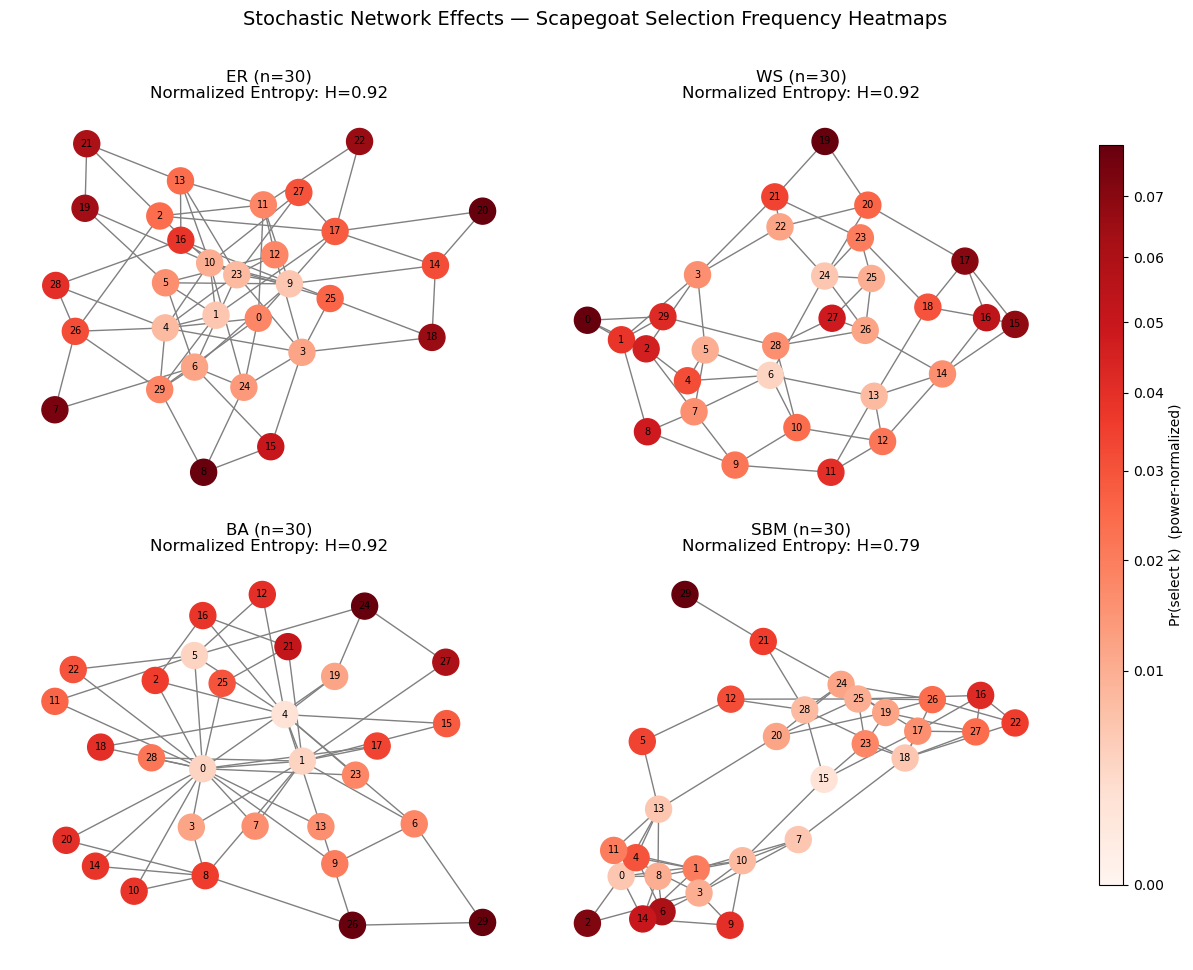

In [ ]:
# Step 4.1: selection-frequency heatmaps 

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def selection_frequency_on_graph(
    G,
    trials=500,
    base_seed=1000,
    mu_p=0.0, sigma_p=1.5,     # trust heterogeneity
    beta0=-2.0, beta1=0.3,     # distance slope
    sigma_eps=1.0,             #   priors
    mode="soft",               #  "hard" (argmin) or "soft" (Gibbs)
    lambda_soft=15.0           # larger: closer to argmin; smaller: flatter
):
    nodes = list(G.nodes())
    count = {k: 0.0 for k in nodes}

    for t in range(trials):
        res = run_extensions_on_graph_deterministic(
            G,
            mu_p=mu_p, sigma_p=sigma_p,
            beta0=beta0, beta1=beta1, sigma_eps=sigma_eps,
            seed=base_seed + t
        )
        R = res["R_map"]

        if mode == "hard":
            winners = res["scapegoats"]
            w = 1.0 / len(winners)
            for k in winners:
                count[k] += w
        else:
            # soft-min over all nodes
            R_vals = np.array([R[k] for k in nodes], dtype=float)
            R_min = R_vals.min()
            logits = -lambda_soft * (R_vals - R_min)
            logits -= logits.max()  # stabilize
            p = np.exp(logits)
            p /= p.sum()
            rng = np.random.default_rng(base_seed + 10_000 + t)
            idx = rng.choice(len(nodes), p=p)
            count[nodes[idx]] += 1.0

    return {k: count[k] / trials for k in nodes}  # selection probability


def plot_selection_heat_four(
    graphs_dict,
    trials=500,
    base_seed=1000,
    mu_p=0.0, sigma_p=1.5,
    beta0=-2.0, beta1=0.3, sigma_eps=1.0,
    mode="soft",
    lambda_soft=15.0,
    layout_seed=42,
    cmap_name="Reds",         # colormap name
    vmax_percentile=95,         # clip global vmax at this percentile across panels
    gamma=0.6               # PowerNorm gamma < 1 boosts low values
):
    # Monte Carlo frequencies for each graph 
    ordered = list(graphs_dict.items())
    freqs = {}
    all_values = []
    for name, G in ordered:
        f = selection_frequency_on_graph(
            G,
            trials=trials,
            base_seed=base_seed,
            mu_p=mu_p, sigma_p=sigma_p,
            beta0=beta0, beta1=beta1, sigma_eps=sigma_eps,
            mode=mode, lambda_soft=lambda_soft
        )
        freqs[name] = f
        all_values.extend(list(f.values()))

    # Global vmax via percentile; PowerNorm for small values
    all_values = np.array(all_values, dtype=float)
    vmax = float(np.percentile(all_values, vmax_percentile)) if all_values.size else 1.0
    vmax = max(vmax, 1e-6)
    norm = mcolors.PowerNorm(gamma=gamma, vmin=0.0, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for ax, (name, G) in zip(axes, ordered):
        pos = nx.spring_layout(G, seed=layout_seed)
        vals = np.array([freqs[name][n] for n in G.nodes()], dtype=float)

        colors = cmap(norm(vals))

        nx.draw_networkx_nodes(
            G, pos, ax=ax,
            node_size=350,
            node_color=colors   
        )
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color="gray", width=1.0)
        nx.draw_networkx_labels(
            G, pos, ax=ax,
            labels={n: str(n) for n in G.nodes()},
            font_size=7
        )
        clean_name = name.split(", seed")[0] + ")"
        # Normalized entropy (0=locked, 1=uniform) as a small diagnostic
        p = vals
        H = -np.sum(p[p > 0] * np.log(p[p > 0])) / np.log(max(1, G.number_of_nodes()))
        ax.set_title(f"{clean_name}\nNormalized Entropy: H={H:.2f}")
        ax.axis("off")

    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    fig.patch.set_facecolor("white")
    fig.suptitle("Stochastic Network Effects — Scapegoat Selection Frequency Heatmaps", fontsize=14, y=0.995)
    fig.tight_layout(rect=[0.0, 0.03, 0.90, 0.985])

    cax = fig.add_axes([0.92, 0.12, 0.02, 0.74])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label("Pr(select k)  (power-normalized)")
    plt.show()


# set mode="hard" and restore (sigma_p=1.0, beta1=0.6, sigma_eps=0.5): original deterministic look.
plot_selection_heat_four(
    graphs,
    trials=500,                 
    base_seed=1000,
    mu_p=0.0, sigma_p=1.5,     
    beta0=-2.0, beta1=0.3,      
    sigma_eps=1.0,              
    mode="soft",                
    lambda_soft=15.0,          
    layout_seed=42,
    cmap_name="Reds",
    vmax_percentile=95,
    gamma=0.6
)


In [ ]:
# Step 4.2: probabilities vs. centralities

import numpy as np
import networkx as nx

def _sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def _rng_from(seed, *keys):
    h = hash((seed,) + tuple(keys)) & 0xFFFFFFFF
    return np.random.default_rng(h)

def _laplacian(G):
    W = nx.to_numpy_array(G, weight=None)
    d = W.sum(axis=1)
    return np.diag(d) - W

def sample_alpha_det(n, seed=0):
    rng = _rng_from(seed, "alpha")
    return rng.uniform(0.0, 1.0, size=n)

def sample_p_det(n, mu_p=0.0, sigma_p=1.0, seed=0):
    rng = _rng_from(seed, "p")
    eta = rng.normal(0.0, sigma_p, size=n)
    return _sigmoid(mu_p + eta)

def stochastic_prior_for_k_det(G, k, beta0=-2.0, beta1=0.6, sigma_eps=0.5, base_seed=0):
    rng = _rng_from(base_seed, "pi", int(k))
    nodes = list(G.nodes())
    lengths = nx.single_source_shortest_path_length(G, k)
    dvec = np.array([lengths.get(i, np.inf) for i in nodes], dtype=float)
    eps  = rng.normal(0.0, sigma_eps, size=len(nodes))
    return _sigmoid(beta0 + beta1 * dvec + eps), nodes

def posterior_b_from_pi_p(pi_k, p_vec):
    denom = pi_k + p_vec * (1.0 - pi_k)
    denom = np.where(denom == 0.0, 1e-12, denom)
    return pi_k / denom

def equilibrium_x(L, b_vec, alpha_vec):
    A = np.diag(1.0 - alpha_vec) + (np.diag(alpha_vec) @ L)
    rhs = (1.0 - alpha_vec) * b_vec
    return np.linalg.solve(A, rhs)

def reputational_cost_R(x_vec):
    return float(np.sum(1.0 - x_vec))

def run_extensions_on_graph_deterministic(
    G,
    mu_p=0.0, sigma_p=1.0,
    beta0=-2.0, beta1=0.6, sigma_eps=0.5,
    seed=12345
):
    nodes = list(G.nodes())
    n = len(nodes)

    alpha = sample_alpha_det(n, seed=seed)
    p_vec = sample_p_det(n, mu_p=mu_p, sigma_p=sigma_p, seed=seed)

    L = _laplacian(G)
    R_map, x_map = {}, {}

    for k in nodes:
        pi_k, _ = stochastic_prior_for_k_det(G, k, beta0=beta0, beta1=beta1, sigma_eps=sigma_eps, base_seed=seed)
        b_k = posterior_b_from_pi_p(pi_k, p_vec)
        x_k = equilibrium_x(L, b_k, alpha)
        R_map[k] = reputational_cost_R(x_k)
        x_map[k] = x_k

    min_R = min(R_map.values())
    scapegoats = [k for k, v in R_map.items() if abs(v - min_R) < 1e-12]
    return {"R_map": R_map, "x_map": x_map, "scapegoats": scapegoats}

def decay_centrality_manual(G, alpha=0.5):
    """
    C_dec(i) = Σ_{j≠i} α^{d(i,j)}, with shortest-path distances; unreachable pairs contribute 0.
    """
    lengths = dict(nx.all_pairs_shortest_path_length(G))
    dc = {}
    for i in G.nodes():
        s = 0.0
        Li = lengths.get(i, {})
        for j in G.nodes():
            if j == i:
                continue
            d = Li.get(j, np.inf)
            if np.isfinite(d):
                s += (alpha ** d)
        dc[i] = s
    return dc

def _gen_graph(model, n, seed):
    rng = np.random.default_rng(seed)
    if model == "ER":
        G = nx.fast_gnp_random_graph(n, 0.15, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "WS":
        k, beta = 4, 0.2
        if k % 2 == 1: k += 1
        k = max(2, min(k, n - 1 - (n - 1) % 2))
        G = nx.watts_strogatz_graph(n, k, beta, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "BA":
        G = nx.barabasi_albert_graph(n, 2, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "SBM":
        sizes = [n // 2, n - n // 2]
        p_in, p_out = 0.25, 0.02
        P = np.full((2, 2), p_out); np.fill_diagonal(P, p_in)
        G = nx.stochastic_block_model(sizes, P, seed=int(rng.integers(1, 1_000_000_000)))
    else:
        raise ValueError(model)
    # ensure connectivity (take LCC if needed)
    if not nx.is_connected(G):
        cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(cc).copy()
    return G

def _selection_frequency_one_param(G, trials, base_seed, mu_p, sigma_p, beta0, beta1, sigma_eps,
                                   lambda_soft=15.0):
    nodes = list(G.nodes())
    count = {k: 0.0 for k in nodes}

    for t in range(trials):
        res = run_extensions_on_graph_deterministic(
            G, mu_p=mu_p, sigma_p=sigma_p,
            beta0=beta0, beta1=beta1, sigma_eps=sigma_eps,
            seed=base_seed + t
        )
        R_map = res["R_map"]
        R_vals = np.array([R_map[k] for k in nodes], dtype=float)
        R_min  = R_vals.min()
        logits = -lambda_soft * (R_vals - R_min)
        logits -= logits.max()
        p = np.exp(logits); p /= p.sum()
        rng = np.random.default_rng(base_seed + 10_000 + t)
        idx = int(rng.choice(len(nodes), p=p))
        count[nodes[idx]] += 1.0

    return {k: count[k] / trials for k in nodes}

def _parameter_marginal_probs(G, param_pool, trials, base_seed,
                              mu_p, sigma_p, beta0, lambda_soft):
    nodes = list(G.nodes())
    acc = np.zeros(len(nodes), dtype=float)
    for i, (b1, s_eps) in enumerate(param_pool):
        f = _selection_frequency_one_param(
            G, trials=trials, base_seed=base_seed + 1_000_000 * i,
            mu_p=mu_p, sigma_p=sigma_p, beta0=beta0, beta1=b1, sigma_eps=s_eps,
            lambda_soft=lambda_soft
        )
        acc += np.array([f[n] for n in nodes], dtype=float)
    acc /= len(param_pool)
    return {n: acc[i] for i, n in enumerate(nodes)}

# Robust percentile normalization 
def _percentile_norm(values):
    v = np.asarray(values, dtype=float)
    n = v.size
    if n == 0:
        return np.array([], dtype=float)

    order = np.argsort(v, kind="mergesort")
    v_sorted = v[order]

    ranks_sorted = np.empty(n, dtype=float)
    base = np.arange(n, dtype=float)

    diff = np.r_[True, v_sorted[1:] != v_sorted[:-1]]
    run_starts = np.flatnonzero(diff)
    run_ends   = np.r_[run_starts[1:], n]  # exclusive

    for a, b in zip(run_starts, run_ends):
        avg = (a + b - 1) / 2.0
        ranks_sorted[a:b] = avg

    ranks = np.empty(n, dtype=float)
    ranks[order] = ranks_sorted
    return (ranks + 1.0) / n

# config
N = 30
GRAPH_MODELS = ["ER", "WS", "BA", "SBM"]

M_GRAPHS_PER_MODEL = 5
TRIALS_PER_PARAM   = 500
BASE_SEED          = 20231011

LAMBDA_SOFT = 15.0
MU_P        = 0.0
SIGMA_P     = 1.5
BETA0       = -2.0

# Parameter pool 
PARAM_POOL = [(b1, s_eps) for b1 in [0.2, 0.3, 0.6] for s_eps in [0.5, 1.0, 1.5]]

DECAY_ALPHA = 0.5

# simulate and pool
rng_global = np.random.default_rng(BASE_SEED)

pooled_data = {m: {"p": [], "deg": [], "decay": [], "btw": [], "eig": []}
               for m in GRAPH_MODELS}

for model in GRAPH_MODELS:
    for m in range(M_GRAPHS_PER_MODEL):
        gseed = int(rng_global.integers(1, 1_000_000_000))
        G = _gen_graph(model, N, gseed)
        nodes = list(G.nodes())

        f_bar = _parameter_marginal_probs(
            G, PARAM_POOL, TRIALS_PER_PARAM, base_seed=BASE_SEED + 10_000*m,
            mu_p=MU_P, sigma_p=SIGMA_P, beta0=BETA0, lambda_soft=LAMBDA_SOFT
        )
        probs = np.array([f_bar[n] for n in nodes], dtype=float)

        deg_raw = np.array([G.degree(n) for n in nodes], dtype=float)
        dec_raw = np.array(list(decay_centrality_manual(G, DECAY_ALPHA).values()), dtype=float)
        btw_raw = np.array(list(nx.betweenness_centrality(G, normalized=True).values()), dtype=float)
        try:
            eig_raw = np.array(list(nx.eigenvector_centrality_numpy(G).values()), dtype=float)
        except Exception:
            eig_raw = np.array(list(nx.eigenvector_centrality(G, max_iter=2000).values()), dtype=float)

        # Percentile-normalize within graph
        deg_p = _percentile_norm(deg_raw)
        dec_p = _percentile_norm(dec_raw)
        btw_p = _percentile_norm(btw_raw)
        eig_p = _percentile_norm(eig_raw)

        pooled_data[model]["p"].extend(probs.tolist())
        pooled_data[model]["deg"].extend(deg_p.tolist())
        pooled_data[model]["decay"].extend(dec_p.tolist())
        pooled_data[model]["btw"].extend(btw_p.tolist())
        pooled_data[model]["eig"].extend(eig_p.tolist())

Bprime_meta = {
    "N": N,
    "LAMBDA_SOFT": LAMBDA_SOFT,
    "SIGMA_P": SIGMA_P,
    "M_GRAPHS_PER_MODEL": M_GRAPHS_PER_MODEL,
    "NUM_PARAMS": len(PARAM_POOL),
    "TRIALS_PER_PARAM": TRIALS_PER_PARAM,
    "DECAY_ALPHA": DECAY_ALPHA,
}
print("Done. `pooled_data` and `Bprime_meta` are ready for plotting in Cell 2.")


Done. `pooled_data` and `Bprime_meta` are ready for plotting in Cell 2.


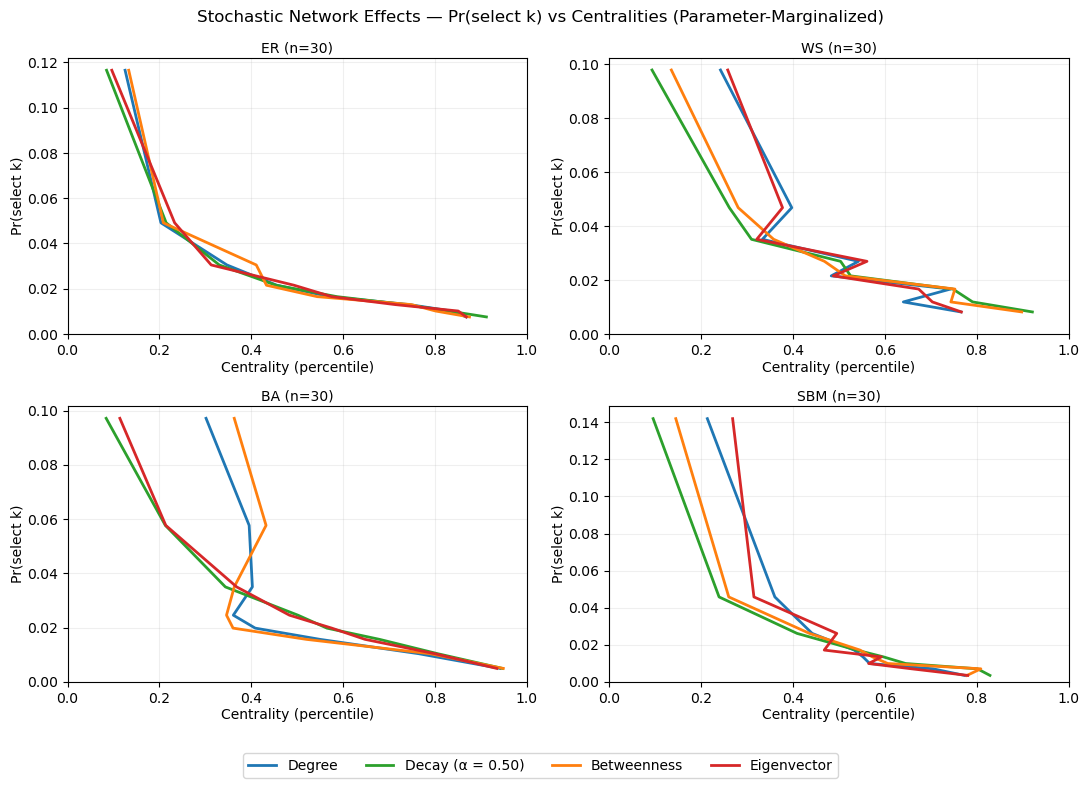

In [ ]:
# plot
import numpy as np
import matplotlib.pyplot as plt

def _binned_mean(x, y, num_bins=8):
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    qs = np.linspace(0, 1, num_bins + 1)
    edges = np.unique(np.quantile(x, qs))
    xc, ym = [], []
    for i in range(len(edges) - 1):
        lo, hi = edges[i], edges[i + 1]
        sel = (x >= lo) & (x < hi) if i < len(edges) - 2 else (x >= lo) & (x <= hi)
        if not np.any(sel):
            continue
        xc.append(float(np.mean(x[sel])))
        ym.append(float(np.mean(y[sel])))
    return np.array(xc), np.array(ym)

GRAPH_MODELS = ["ER", "WS", "BA", "SBM"]
NUM_BINS = 8
CENT_COLORS = {
    "deg":   "#1f77b4",
    "decay": "#2ca02c",
    "btw":   "#ff7f0e",
    "eig":   "#d62728",
}

fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=False)
axes = axes.ravel()

for ax, model in zip(axes, GRAPH_MODELS):
    x = np.array(pooled_data[model]["p"], dtype=float)

    for key in ["deg", "decay", "btw", "eig"]:
        y = np.array(pooled_data[model][key], dtype=float)
        xc, ym = _binned_mean(x, y, num_bins=NUM_BINS)
        ax.plot(ym, xc, lw=2, color=CENT_COLORS[key], label=key)

    ax.set_title(f"{model} (n=30)", fontsize=10, pad=4)
    ax.set_xlabel("Centrality (percentile)", labelpad=2)
    ax.set_ylabel("Pr(select k)", labelpad=2)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, None)
    ax.grid(alpha=0.2)

handles = [plt.Line2D([0],[0], color=CENT_COLORS[k], lw=2, label=lab)
           for k, lab in zip(
               ["deg","decay","btw","eig"],
               ["Degree",
                f"Decay (α = {Bprime_meta.get('DECAY_ALPHA', 0.5):.2f})",
                "Betweenness","Eigenvector"]
           )]
fig.legend(handles=handles, loc="lower center", ncol=4, frameon=True,
           bbox_to_anchor=(0.5, -0.0001), borderaxespad=0.0)

meta = Bprime_meta
fig.suptitle(
    (f"Stochastic Network Effects — Pr(select k) vs Centralities (Parameter-Marginalized)"),
    y=0.96, fontsize=12
)
fig.subplots_adjust(left=0.07, right=0.98, top=0.9, bottom=0.12,
                    wspace=0.18, hspace=0.26)
plt.show()

In [ ]:
# Step 4.3: entropy

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def _gen_graph(model, n, seed):
    """Sample a connected graph for the given model."""
    rng = np.random.default_rng(seed)
    if model == "ER":
        G = nx.fast_gnp_random_graph(n, 0.15, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "WS":
        k, beta = 4, 0.2
        if k % 2 == 1: k += 1
        k = max(2, min(k, n - 1 - (n - 1) % 2))
        G = nx.watts_strogatz_graph(n, k, beta, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "BA":
        G = nx.barabasi_albert_graph(n, 2, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "SBM":
        sizes = [n//2, n - n//2]; p_in, p_out = 0.25, 0.02
        P = np.full((2,2), p_out); np.fill_diagonal(P, p_in)
        G = nx.stochastic_block_model(sizes, P, seed=int(rng.integers(1, 1_000_000_000)))
    else:
        raise ValueError(model)
    if not nx.is_connected(G):
        cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(cc).copy()
    return G

def _selection_probs_softmin(G, trials, base_seed,
                             mu_p, sigma_p, beta0, beta1, sigma_eps, lam=15.0):
    nodes = list(G.nodes())
    cnt = {k: 0.0 for k in nodes}
    for t in range(trials):
        res = run_extensions_on_graph_deterministic(
            G, mu_p=mu_p, sigma_p=sigma_p,
            beta0=beta0, beta1=beta1, sigma_eps=sigma_eps,
            seed=base_seed + t
        )
        R = np.array([res["R_map"][k] for k in nodes], float)
        z = -lam * (R - R.min())
        z -= z.max()
        p = np.exp(z); p /= p.sum()
        idx = int(np.random.default_rng(base_seed + 10_000 + t).choice(len(nodes), p=p))
        cnt[nodes[idx]] += 1.0
    return {k: cnt[k] / trials for k in nodes}

def _normalized_entropy(p_map):
    p = np.array(list(p_map.values()), float)
    n = p.size
    mask = p > 0
    H = -np.sum(p[mask] * np.log(p[mask]))
    return float(np.clip(H / np.log(n) if n > 1 else 0.0, 0.0, 1.0))

# simulate
def simulate_entropy_grids(
    models=("ER","WS","BA","SBM"),
    n=30,
    beta1_grid=(0.2,0.4,0.6,0.8),
    sigma_pi_grid=(0.3,0.6,1.0,1.5),
    m_graphs=5,
    trials=500,
    base_seed=20231011,
    # fixed decision & trust parameters
    lam=15.0, mu_p=0.0, sigma_p=1.5, beta0=-2.0
):
    rng = np.random.default_rng(base_seed)
    results = {}
    for model in models:
        H = np.zeros((len(sigma_pi_grid), len(beta1_grid)), float)
        for j, s_eps in enumerate(sigma_pi_grid):
            for i, b1 in enumerate(beta1_grid):
                hs = []
                for m in range(m_graphs):
                    G = _gen_graph(model, n, int(rng.integers(1, 1_000_000_000)))
                    p_map = _selection_probs_softmin(
                        G, trials=trials,
                        base_seed=base_seed + 100_000*(i + 10*j) + 10_000*m,
                        mu_p=mu_p, sigma_p=sigma_p, beta0=beta0,
                        beta1=b1, sigma_eps=s_eps, lam=lam
                    )
                    hs.append(_normalized_entropy(p_map))
                H[j, i] = float(np.mean(hs))
        results[model] = H
    meta = {
        "n": n, "beta1_grid": tuple(beta1_grid), "sigma_pi_grid": tuple(sigma_pi_grid),
        "m_graphs": m_graphs, "trials": trials,
        "lam": lam, "mu_p": mu_p, "sigma_p": sigma_p, "beta0": beta0,
        "models": tuple(models)
    }
    return results, meta

results_C, meta_C = simulate_entropy_grids(
    models=("ER","WS","BA","SBM"),
    n=30,
    beta1_grid=(0.2,0.4,0.6,0.8),
    sigma_pi_grid=(0.3,0.6,1.0,1.5),
    m_graphs=10,    
    trials=1000,   
    base_seed=20231011,
    lam=15.0, mu_p=0.0, sigma_p=1.5, beta0=-2.0
)


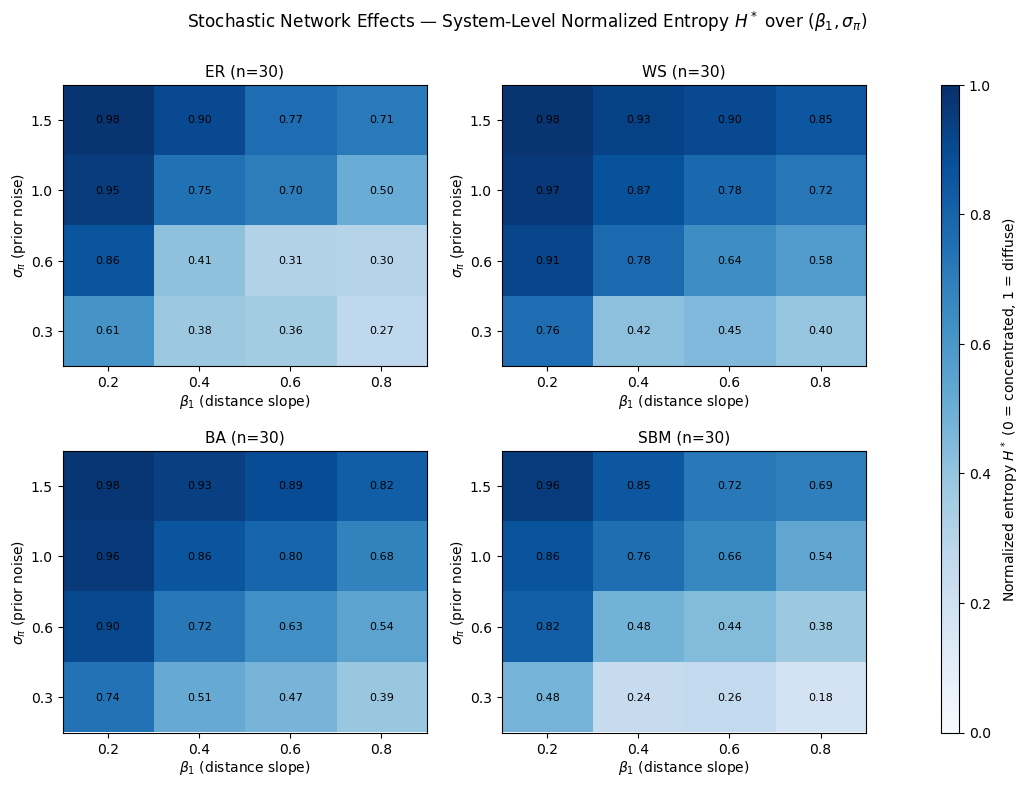

In [ ]:
# plot
from matplotlib.gridspec import GridSpec

def plot_entropy_heatmaps(results, meta,
                          cmap="Blues",
                          annotate=True,
                          suptitle=None,
                          ann_fs=8,
                          wspace=0.30, hspace=0.30,
                          left=0.07, right=0.90, bottom=0.07, top=0.89,  # ↓ slightly reduced top to add more space above
                          cbar_width=0.05):

    # retrieve grids and labels 
    models = meta["models"]
    beta1_grid = meta["beta1_grid"]
    sigma_pi_grid = meta["sigma_pi_grid"]

    fig = plt.figure(figsize=(10.8, 7.9))
    gs = GridSpec(2, 3, figure=fig,
                  width_ratios=[1, 1, cbar_width],
                  wspace=wspace, hspace=hspace)

    ax00 = fig.add_subplot(gs[0, 0])
    ax01 = fig.add_subplot(gs[0, 1])
    ax10 = fig.add_subplot(gs[1, 0])
    ax11 = fig.add_subplot(gs[1, 1])
    axes = [ax00, ax01, ax10, ax11]

    cax = fig.add_subplot(gs[:, 2])
    vmin, vmax = 0.0, 1.0

    last_im = None
    for ax, model in zip(axes, models):
        H = results[model]
        im = ax.imshow(H, origin="lower", vmin=vmin, vmax=vmax,
                       cmap=cmap, aspect="auto")
        last_im = im

        ax.set_xticks(range(len(beta1_grid)))
        ax.set_xticklabels([f"{v:.1f}" for v in beta1_grid])
        ax.set_yticks(range(len(sigma_pi_grid)))
        ax.set_yticklabels([f"{v:.1f}" for v in sigma_pi_grid])
        ax.set_xlabel(r"$\beta_1$ (distance slope)", labelpad=2)
        ax.set_ylabel(r"$\sigma_\pi$ (prior noise)", labelpad=2)
        ax.set_title(f"{model} (n=30)", pad=6, fontsize=11)

        # Annotate each cell with numeric values
        if annotate:
            for j in range(len(sigma_pi_grid)):
                for i in range(len(beta1_grid)):
                    ax.text(i, j, f"{H[j, i]:.2f}",
                            ha="center", va="center",
                            fontsize=ann_fs, color="black")

    cbar = fig.colorbar(last_im, cax=cax)
    cbar.set_label(r"Normalized entropy $H^*$ (0 = concentrated, 1 = diffuse)",
                   labelpad=6)

    if suptitle is None:
        suptitle = (
            "Stochastic Network Effects — System-Level Normalized Entropy $H^*$ over $(\\beta_1, \\sigma_\\pi)$"
        )

    # Move the title further away from panels
    fig.suptitle(suptitle, y=0.985, fontsize=12.2) 
    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top)

    plt.show()

# Example call
plot_entropy_heatmaps(results_C, meta_C, cmap="Blues", annotate=True)


---

### **Extension 5 — Identity–Structure Interaction (Social Identity Layer)**

To incorporate **social identity bias** and capture how group membership interacts with structural priors,  
we introduce a minimal yet expressive *identity–structure interaction* mechanism.  
Each agent belongs to a group label $g_i \in \{\text{in}, \text{out}\}$,  
representing whether the agent is part of the majority (in-group) or a marginalized minority (out-group).

The key assumption is that **in-group observers** systematically overestimate  
the guilt of **out-group targets**, while all other combinations remain unbiased.

Formally, the structural prior $\pi_i^{(k)}$ from the informational layer  
is adjusted through an **identity-dependent logit shift**:

$$
\operatorname{logit}\!\big(\tilde{\pi}_i^{(k)}\big)
= \operatorname{logit}\!\big(\pi_i^{(k)}\big)
+ \beta\,\mathbf{1}\{g_i=\text{in},\,g_k=\text{out}\},
$$

which yields the modified prior

$$
\tilde{\pi}_i^{(k)}
= \frac{e^{\beta}\pi_i^{(k)}}{(1-\pi_i^{(k)})+e^{\beta}\pi_i^{(k)}}.
$$

- $\beta > 0$: strength of **in→out bias** (log-odds increase)  
- $\beta = 0$: no bias (baseline structure-only case)  
- $\beta < 0$: reverse bias (out-group sympathy)  

This transformation strictly ensures $0 < \tilde{\pi}_i^{(k)} < 1$  
and affects only the in→out pairs; other beliefs remain unchanged.

This extension captures how **structural susceptibility** (e.g., distance or centrality)  
interacts with **group identity** to amplify perceived blame toward marginalized nodes—  
a clean and tractable form of **structure × identity interaction**.

---

### **Summary of Parameters**

| Symbol | Description | Typical Setting |
|:--:|:--|:--|
| $g_i, g_k$ | group identity (0 = in-group, 1 = out-group) | assigned exogenously |
| $\beta$ | log-odds bias strength | $\beta = 0.5–1.5$ |
| $\tilde{\pi}_i^{(k)}$ | identity-adjusted prior belief | via logit shift |
| — | bias direction | only active for in → out |

---

Together with the previous four layers,  
this extension introduces a **social identity layer** that interacts multiplicatively with the structural priors,  
embedding **group-based bias** in a mathematically consistent and equilibrium-preserving way.


In [ ]:
# step 5: identity–structure interaction

import numpy as np
import networkx as nx

def _sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

def _rng_from(seed, *keys):
    h = hash((seed,) + tuple(keys)) & 0xFFFFFFFF
    return np.random.default_rng(h)

def _laplacian(G):
    W = nx.to_numpy_array(G, weight=None)
    d = W.sum(axis=1)
    return np.diag(d) - W

def sample_alpha_det(n, seed=0):
    rng = _rng_from(seed, "alpha")
    return rng.uniform(0.0, 1.0, size=n)

def sample_p_det(n, mu_p=0.0, sigma_p=1.0, seed=0):
    rng = _rng_from(seed, "p")
    eta = rng.normal(0.0, sigma_p, size=n)
    return _sigmoid(mu_p + eta)

def stochastic_prior_for_k_det(G, k, beta0=-2.0, beta1=0.6, sigma_eps=0.5, base_seed=0):
    rng = _rng_from(base_seed, "pi", int(k))
    nodes = list(G.nodes())
    lengths = nx.single_source_shortest_path_length(G, k)
    dvec = np.array([lengths.get(i, np.inf) for i in nodes], dtype=float)
    eps  = rng.normal(0.0, sigma_eps, size=len(nodes))
    return _sigmoid(beta0 + beta1 * dvec + eps), nodes

def apply_logit_bias_in_to_out(pi_k, g_obs_vec, gk, beta_id):
    if beta_id == 0.0 or gk == 0:
        return pi_k
    mask = (g_obs_vec == 0) & (gk == 1)
    odds  = np.divide(pi_k, 1.0 - pi_k, out=np.zeros_like(pi_k), where=(pi_k < 1.0))
    odds[mask] = np.exp(beta_id) * odds[mask]
    pik_new = np.divide(odds, 1.0 + odds)
    return np.clip(pik_new, 1e-12, 1.0 - 1e-12)

def posterior_b_from_pi_p(pi_k, p_vec):
    denom = pi_k + p_vec * (1.0 - pi_k)
    denom = np.where(denom == 0.0, 1e-12, denom)
    return pi_k / denom

def equilibrium_x(L, b_vec, alpha_vec):
    A = np.diag(1.0 - alpha_vec) + (np.diag(alpha_vec) @ L)
    rhs = (1.0 - alpha_vec) * b_vec
    return np.linalg.solve(A, rhs)

def reputational_cost_R(x_vec):
    return float(np.sum(1.0 - x_vec))

def decay_centrality_manual(G, alpha=0.5):
    lengths = dict(nx.all_pairs_shortest_path_length(G))
    dc = {}
    for i in G.nodes():
        s = 0.0
        Li = lengths.get(i, {})
        for j in G.nodes():
            if j == i: continue
            d = Li.get(j, np.inf)
            if np.isfinite(d):
                s += (alpha ** d)
        dc[i] = s
    return dc

def _gen_graph(model, n, seed):
    rng = np.random.default_rng(seed)
    if model == "ER":
        G = nx.fast_gnp_random_graph(n, 0.15, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "WS":
        k, beta = 4, 0.2
        if k % 2 == 1: k += 1
        k = max(2, min(k, n - 1 - (n - 1) % 2))
        G = nx.watts_strogatz_graph(n, k, beta, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "BA":
        G = nx.barabasi_albert_graph(n, 2, seed=int(rng.integers(1, 1_000_000_000)))
    elif model == "SBM":
        sizes = [n // 2, n - n // 2]
        p_in, p_out = 0.25, 0.02
        P = np.full((2, 2), p_out); np.fill_diagonal(P, p_in)
        G = nx.stochastic_block_model(sizes, P, seed=int(rng.integers(1, 1_000_000_000)))
    else:
        raise ValueError(model)
    # ensure connectivity (take LCC if needed)
    if not nx.is_connected(G):
        cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(cc).copy()
    return G

def _node_groups(G, model, seed=0):
    nodes = list(G.nodes())
    # For SBM, use planted block if present; otherwise reproducible Bernoulli(0.5)
    if model == "SBM" and all("block" in G.nodes[n] for n in nodes):
        return {n: int(G.nodes[n]["block"]) for n in nodes}
    rng = np.random.default_rng(seed)
    return {n: int(rng.integers(0, 2)) for n in nodes}

def _selection_frequency_one_param(
    G, g_map, trials, base_seed, mu_p, sigma_p, beta0, beta1, sigma_eps,
    beta_id, lambda_soft=15.0
):
    nodes = list(G.nodes()); n = len(nodes)
    g_obs_vec = np.array([g_map[i] for i in nodes], dtype=int)
    count = {k: 0.0 for k in nodes}

    for t in range(trials):
        alpha = sample_alpha_det(n, seed=base_seed + 11 + t)
        p_vec = sample_p_det(n, mu_p=mu_p, sigma_p=sigma_p, seed=base_seed + 13 + t)
        L = _laplacian(G)

        R_map = {}
        for k in nodes:
            pi_k, _ = stochastic_prior_for_k_det(G, k, beta0=beta0, beta1=beta1,
                                                 sigma_eps=sigma_eps, base_seed=base_seed + 97 + t)
            gk = g_map[k]
            pi_k = apply_logit_bias_in_to_out(pi_k, g_obs_vec, gk, beta_id)  # <<< identity layer
            b_k  = posterior_b_from_pi_p(pi_k, p_vec)
            x_k  = equilibrium_x(L, b_k, alpha)
            R_map[k] = reputational_cost_R(x_k)

        R_vals = np.array([R_map[k] for k in nodes], dtype=float)
        R_min  = R_vals.min()
        logits = -lambda_soft * (R_vals - R_min)
        logits -= logits.max()
        p_sel = np.exp(logits); p_sel /= p_sel.sum()
        rng = np.random.default_rng(base_seed + 10_000 + t)
        idx = int(rng.choice(len(nodes), p=p_sel))
        count[nodes[idx]] += 1.0

    return {k: count[k] / trials for k in nodes}

def _parameter_marginal_probs(G, g_map, param_pool, trials, base_seed,
                              mu_p, sigma_p, beta0, beta_id, lambda_soft):
    nodes = list(G.nodes())
    acc = np.zeros(len(nodes), dtype=float)
    for i, (b1, s_eps) in enumerate(param_pool):
        f = _selection_frequency_one_param(
            G, g_map, trials=trials, base_seed=base_seed + 1_000_000 * i,
            mu_p=mu_p, sigma_p=sigma_p, beta0=beta0, beta1=b1, sigma_eps=s_eps,
            beta_id=beta_id, lambda_soft=lambda_soft
        )
        acc += np.array([f[n] for n in nodes], dtype=float)
    acc /= len(param_pool)
    return {n: acc[i] for i, n in enumerate(nodes)}

# percentile normalization 
def _percentile_norm(values):
    v = np.asarray(values, dtype=float)
    n = v.size
    if n == 0:
        return np.array([], dtype=float)

    order = np.argsort(v, kind="mergesort")
    v_sorted = v[order]

    ranks_sorted = np.empty(n, dtype=float)
    diff = np.r_[True, v_sorted[1:] != v_sorted[:-1]]
    run_starts = np.flatnonzero(diff)
    run_ends   = np.r_[run_starts[1:], n]  # exclusive
    for a, b in zip(run_starts, run_ends):
        avg = (a + b - 1) / 2.0
        ranks_sorted[a:b] = avg

    ranks = np.empty(n, dtype=float)
    ranks[order] = ranks_sorted
    return (ranks + 1.0) / n

# config
N = 30
GRAPH_MODELS = ["ER", "WS", "BA", "SBM"]

M_GRAPHS_PER_MODEL = 5
TRIALS_PER_PARAM   = 500
BASE_SEED          = 20231011

LAMBDA_SOFT = 15.0
MU_P        = 0.0
SIGMA_P     = 1.5
BETA0       = -2.0

# Identity bias (log-odds shift for in to out)
BETA_ID     = 1.0

# Parameter pool
PARAM_POOL = [(b1, s_eps) for b1 in [0.2, 0.3, 0.6] for s_eps in [0.5, 1.0, 1.5]]

DECAY_ALPHA = 0.5

# simulate
rng_global = np.random.default_rng(BASE_SEED)

pooled_data = {m: {"p": [], "deg": [], "decay": [], "btw": [], "eig": [], "grp": []}
               for m in GRAPH_MODELS}

for model in GRAPH_MODELS:
    for m in range(M_GRAPHS_PER_MODEL):
        gseed = int(rng_global.integers(1, 1_000_000_000))
        G = _gen_graph(model, N, gseed)
        nodes = list(G.nodes())
        g_map = _node_groups(G, model, seed=gseed)  # 0=in, 1=out

        f_bar = _parameter_marginal_probs(
            G, g_map, PARAM_POOL, TRIALS_PER_PARAM, base_seed=BASE_SEED + 10_000*m,
            mu_p=MU_P, sigma_p=SIGMA_P, beta0=BETA0, beta_id=BETA_ID, lambda_soft=LAMBDA_SOFT
        )
        probs = np.array([f_bar[n] for n in nodes], dtype=float)

        deg_raw = np.array([G.degree(n) for n in nodes], dtype=float)
        dec_raw = np.array(list(decay_centrality_manual(G, DECAY_ALPHA).values()), dtype=float)
        btw_raw = np.array(list(nx.betweenness_centrality(G, normalized=True).values()), dtype=float)
        try:
            eig_raw = np.array(list(nx.eigenvector_centrality_numpy(G).values()), dtype=float)
        except Exception:
            eig_raw = np.array(list(nx.eigenvector_centrality(G, max_iter=2000).values()), dtype=float)

        # Percentile-normalize within graph
        deg_p = _percentile_norm(deg_raw)
        dec_p = _percentile_norm(dec_raw)
        btw_p = _percentile_norm(btw_raw)
        eig_p = _percentile_norm(eig_raw)

        pooled_data[model]["p"].extend(probs.tolist())
        pooled_data[model]["deg"].extend(deg_p.tolist())
        pooled_data[model]["decay"].extend(dec_p.tolist())
        pooled_data[model]["btw"].extend(btw_p.tolist())
        pooled_data[model]["eig"].extend(eig_p.tolist())
        pooled_data[model]["grp"].extend([g_map[n] for n in nodes])

Bprime_meta = {
    "N": N,
    "LAMBDA_SOFT": LAMBDA_SOFT,
    "SIGMA_P": SIGMA_P,
    "M_GRAPHS_PER_MODEL": M_GRAPHS_PER_MODEL,
    "NUM_PARAMS": len(PARAM_POOL),
    "TRIALS_PER_PARAM": TRIALS_PER_PARAM,
    "DECAY_ALPHA": DECAY_ALPHA,
    "BETA_ID": BETA_ID,
}
print("Done. `pooled_data` and `Bprime_meta` are ready for plotting in Cell 2.")


Done. `pooled_data` and `Bprime_meta` are ready for plotting in Cell 2.


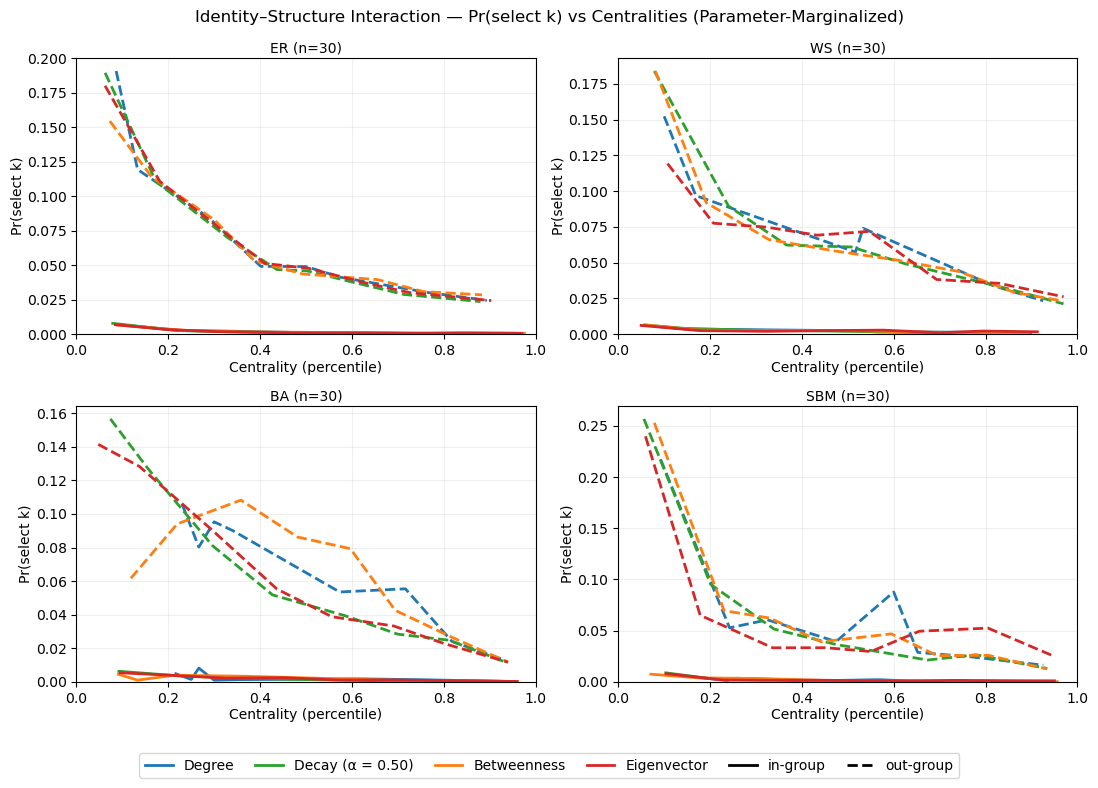

In [ ]:
# plot

import numpy as np
import matplotlib.pyplot as plt

def _binned_mean(x, y, num_bins=8):
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    qs = np.linspace(0, 1, num_bins + 1)
    edges = np.unique(np.quantile(x, qs))
    xc, ym = [], []
    for i in range(len(edges) - 1):
        lo, hi = edges[i], edges[i + 1]
        sel = (x >= lo) & (x < hi) if i < len(edges) - 2 else (x >= lo) & (x <= hi)
        if not np.any(sel):
            continue
        xc.append(float(np.mean(x[sel])))
        ym.append(float(np.mean(y[sel])))
    return np.array(xc), np.array(ym)

GRAPH_MODELS = ["ER", "WS", "BA", "SBM"]
NUM_BINS = 8
CENT_COLORS = {
    "deg":   "#1f77b4",
    "decay": "#2ca02c",
    "btw":   "#ff7f0e",
    "eig":   "#d62728",
}

fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=False)
axes = axes.ravel()

for ax, model in zip(axes, GRAPH_MODELS):
    p   = np.array(pooled_data[model]["p"], dtype=float)         
    grp = np.array(pooled_data[model]["grp"], dtype=int)         

    for key in ["deg", "decay", "btw", "eig"]:
        x = np.array(pooled_data[model][key], dtype=float)      
        color = CENT_COLORS[key]

        # in-group (solid)
        mask_in = (grp == 0)
        if np.any(mask_in):
            xc_in, ym_in = _binned_mean(x[mask_in], p[mask_in], num_bins=NUM_BINS)
            ax.plot(xc_in, ym_in, lw=2, color=color, linestyle='-')

        # out-group (dashed)
        mask_out = (grp == 1)
        if np.any(mask_out):
            xc_out, ym_out = _binned_mean(x[mask_out], p[mask_out], num_bins=NUM_BINS)
            ax.plot(xc_out, ym_out, lw=2, color=color, linestyle='--')

    ax.set_title(f"{model} (n=30)", fontsize=10, pad=4)
    ax.set_xlabel("Centrality (percentile)", labelpad=2)
    ax.set_ylabel("Pr(select k)", labelpad=2)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, None)
    ax.grid(alpha=0.2)

handles = [
    # color
    plt.Line2D([0],[0], color=CENT_COLORS["deg"], lw=2, ls='-', label="Degree"),
    plt.Line2D([0],[0], color=CENT_COLORS["decay"], lw=2, ls='-', label=f"Decay (α = {Bprime_meta.get('DECAY_ALPHA',0.5):.2f})"),
    plt.Line2D([0],[0], color=CENT_COLORS["btw"], lw=2, ls='-', label="Betweenness"),
    plt.Line2D([0],[0], color=CENT_COLORS["eig"], lw=2, ls='-', label="Eigenvector"),
    # line
    plt.Line2D([0],[0], color="k", lw=2, ls='-',  label="in-group"),
    plt.Line2D([0],[0], color="k", lw=2, ls='--', label="out-group")
]

fig.legend(handles=handles,
           loc="lower center",         
           ncol=6,                        
           frameon=True,
           bbox_to_anchor=(0.5, -0.0001),  
           columnspacing=1.5, handletextpad=0.8, borderaxespad=0.0)

meta = Bprime_meta
fig.suptitle(
    "Identity–Structure Interaction — Pr(select k) vs Centralities (Parameter-Marginalized)\n",
    y=0.96, fontsize=12
)
fig.subplots_adjust(left=0.07, right=0.98, top=0.9, bottom=0.12,
                    wspace=0.18, hspace=0.26)
plt.show()
